# CPGs

In [321]:
import numpy as np 
import matplotlib.pyplot as plt
# import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext wurlitzer
# %matplotlib inline
%matplotlib ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


In [2]:
Tlong = 8000  # ms
dt = 0.1      # ms

points_per_bin = 1/dt     # bins 1 ms wide
sampling_frequency = 1e3  # 1 kHz sampling frequency

burn_in_millis = 600      # the first part of the record to discard (ms)

Tshort = 1500 # ms

In [14]:
from scipy.signal import butter, sosfiltfilt, freqz, welch
from scipy.integrate import simpson
from scipy import stats

def bin_spikes(spikes, points_per_bin = 10):
    binned_signal = np.sum( spikes[:(len(spikes)//points_per_bin)*points_per_bin].reshape(-1, points_per_bin),
                        axis=1).squeeze()
    return binned_signal

def beta_power(sn, population):    
    spikes = sn.populations[population].get_data('spikes')
    binned_spikes = bin_spikes(spikes)[burn_in_millis:]
    T = len(binned_spikes)
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg = T/2, # Takes at least 3 windows
                   noverlap= T/4,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')

    beta_mask = (f>=12)&(f<30)
    low_gamma_mask = (f>=30)&(f<50)
    high_gamma_mask = (f>=50)&(f<90)
    
    norm_beta = simpson(PSD[beta_mask], x=f[beta_mask])
    fmean = simpson(f[beta_mask]*PSD[beta_mask]/norm_beta, x=f[beta_mask])

    spectral_norm = simpson(PSD, x=f)
    result = dict(
        fmax = f[np.argmax(PSD)],
        fmean=fmean,
        
        norm_beta_power=simpson(PSD[beta_mask], x=f[beta_mask])/spectral_norm,
        norm_low_gamma_power=simpson(PSD[low_gamma_mask], x=f[low_gamma_mask])/spectral_norm,
        norm_high_gamma_power=simpson(PSD[high_gamma_mask], x=f[high_gamma_mask])/spectral_norm,

        beta_power = simpson(PSD[beta_mask], x=f[beta_mask]),
        low_gamma_power = simpson(PSD[low_gamma_mask], x=f[low_gamma_mask]),
        high_gamma_power = simpson(PSD[high_gamma_mask], x=f[high_gamma_mask]),

        entropy=stats.entropy(PSD/spectral_norm),
    )
    
    return result

def firing_rate(sn, population):
    binned_spikes = bin_spikes(sn.populations[population].get_data('spikes'))
    instantaneous_fr = binned_spikes/sn.populations[pop].n_neurons*1000
    return np.mean(instantaneous_fr)

def bandpass(data, edges, sample_rate, poles = 5):
    sos = butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

def get_PSD(sn, pop, frequency_resolution=0.5, smooth=False):
    spikes = sn.populations[pop].get_data('spikes')
    binned_spikes = bin_spikes(spikes)
    binned_spikes = binned_spikes[burn_in_millis:]
    T = len(binned_spikes)
    # print(f"Mean firing rate {pop} is {np.sum(spikes)/sn.populations[pop].n_neurons/(Tlong/1000) :.1f} Hz")

    N = sampling_frequency/frequency_resolution
    
    if N > T/2:
        print(N)
        print(f"Not enough points to achieve resolution of {frequency_resolution}")
        N = T/2

    nfft = 10_000 if smooth else None
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg=N, 
                   noverlap=N/2,
                   nfft=nfft,
                   scaling='density', 
                   window='hamming')
    # print(f"F resolution { f[1] - f[0] :.2f} Hz")
    norm = simpson(PSD, x=f)
    return f, PSD

def plot_spectrum(sn, scale="log", pops=None):
    if pops is None:
        pops = sn.populations
    fig, axes = plt.subplots(len(pops), 1, sharex=True)
    for ax, pop in zip(axes, pops):
        f, PSD = get_PSD(sn, pop)
        norm = simpson(PSD, x=f)
        ax.plot(f, PSD/norm, label=pop)
        
        ax.set_ylabel(pop)
        ax.set_yscale(scale)
    # print(f"F resolution { f[1] - f[0] :.2f} Hz")
    # plt.yscale('log')
    # plt.legend()
    # plt.ylabel("normalized PSD")
    plt.xlabel("Frequency [Hz]")
    plt.xlim(10, 30)
    fig.set_figheight(8.5)
    return fig

def plot_signals(sn, pops=None):
    if pops is None:
        pops = sn.populations.keys()
    colors = sns.color_palette("rainbow", 10)

    fig, ax = plt.subplot_mosaic([[pop] for pop in pops],sharex=True, figsize=(8,2*len(pops)))

    for pop in pops:    
        binned_spikes = bin_spikes(sn.populations[pop].get_data('spikes'))
        instantaneous_fr = binned_spikes/sn.populations[pop].n_neurons*1000
        
        tt = np.linspace(0, len(instantaneous_fr)/1000, len(instantaneous_fr))
        ax[pop].plot(tt, instantaneous_fr, color="#c3c3c3", label="raw")
            
        ax[pop].plot(tt,np.mean(instantaneous_fr) + bandpass(instantaneous_fr, [12, 30], sampling_frequency), label=r"$\beta$", color=colors[9])
        ax[pop].plot(tt, np.mean(instantaneous_fr)  + bandpass(instantaneous_fr, [30, 90], sampling_frequency), label=r"$\gamma$", color=colors[2])
        
        ax[pop].set_xlim(6, 7)
        ax[pop].set_ylabel(f"{pop} [Hz]")
        ax[pop].legend()
    
    leg = ax[pops[0]].get_legend()
    for a in ax.values():
        a.legend().remove()
    
    fig.legend(handles=leg.legend_handles, loc='upper right')
    
    ax[pops[-1]].set_xlabel("time [s]")
    return fig

In [386]:
from quilt.builder import SpikingNetwork

net = SpikingNetwork.from_yaml("basic_net.yaml", "neurons.yaml")
net.monitorize_spikes()

In [387]:
net.run(time=5000)

Running network consisting of 1000 neurons for 50000 timesteps
--------------------------------------------------
**************************************************
Simulation took 7 s	(0.15148 ms/step)
	Gathering time avg: 0.0017 us/step
	Inject time avg: 2.80458 us/step
Population evolution stats:
	0:
		evolution:	69.4291 us/step	---	138 ns/step/neuron
		spike emission:	3.21832 us/step	---	6 ns/step/neuron
	1:
		evolution:	70.3446 us/step	---	140 ns/step/neuron
		spike emission:	3.15712 us/step	---	6 ns/step/neuron


In [388]:
for pop in net.populations:
    plt.plot(bin_spikes(net.populations[pop].get_data("spikes")), alpha=1)

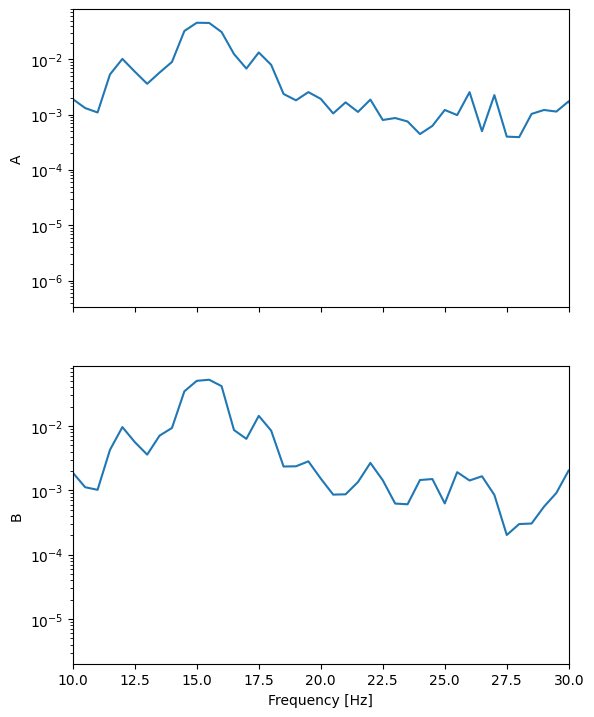

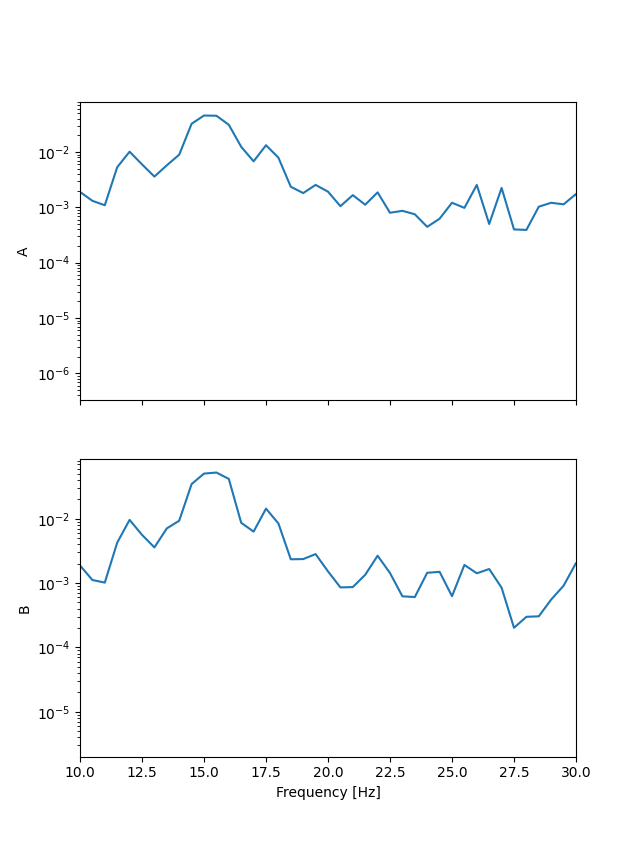

In [389]:
plot_spectrum(net)

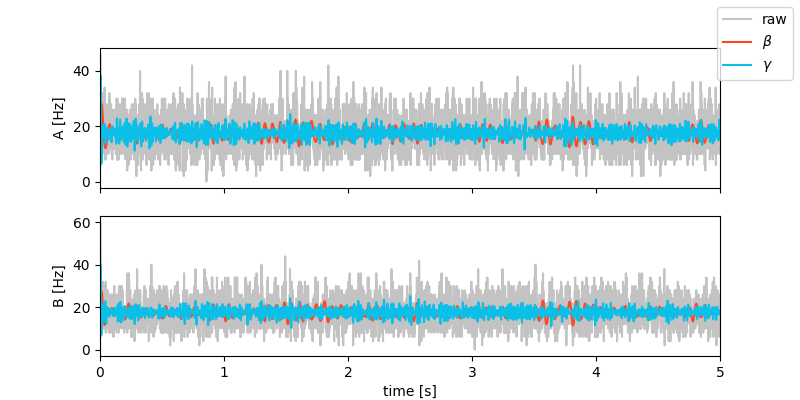

In [397]:
plot_signals(net, pops=["A", "B"])
plt.gca().set_xlim(0,5)
plt.show()

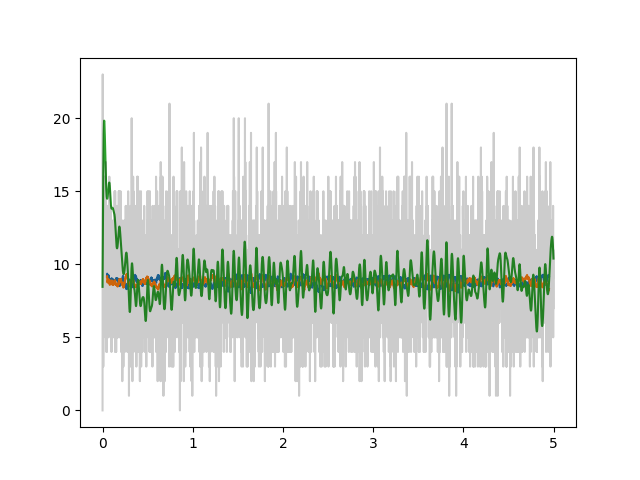

In [398]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

plt.close()  
plt.figure()

window = 100
signal_A = bin_spikes(net.populations["A"].get_data("spikes"))
signal_B = bin_spikes(net.populations["B"].get_data("spikes"))

tt = np.arange(len(signal_A))/1000
avg_t = np.mean(rolling_window(tt, window), axis=1)

plt.plot(avg_t, np.mean(rolling_window(signal_A, window), axis=1))
plt.plot(avg_t, np.mean(rolling_window(signal_B, window), axis=1))

plt.plot(tt, bandpass(signal_A, [1, 30], 1e3) + np.mean(signal_A))

plt.plot(tt, signal_A, color="k", alpha=0.2)
plt.show()

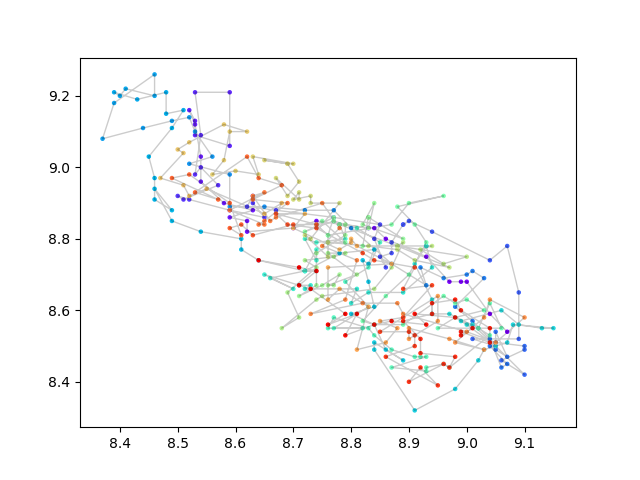

In [399]:
plt.close()
plt.figure()

window = 100
signal_A = bin_spikes(net.populations["A"].get_data("spikes"))
signal_B = bin_spikes(net.populations["B"].get_data("spikes"))

tt = np.arange(len(signal_A))/1000

avg_t = np.mean(rolling_window(tt, window), axis=1)
mask = (avg_t>2.5)&(avg_t<2.9)

plt.plot(np.mean(rolling_window(signal_A, window), axis=1)[mask], 
            np.mean(rolling_window(signal_B, window), axis=1)[mask],
         lw=1, 
         alpha=0.2,
         color="k"
           )

plt.scatter(np.mean(rolling_window(signal_A, window), axis=1)[mask], 
            np.mean(rolling_window(signal_B, window), axis=1)[mask],
           s=5,
            c=avg_t[mask],
            cmap="rainbow"
           )

plt.show()

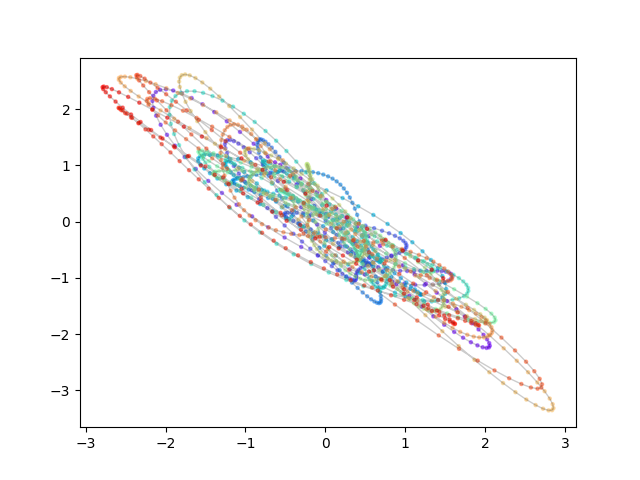

In [422]:
plt.close()
plt.figure()

window = 100
signal_A = bin_spikes(net.populations["A"].get_data("spikes"))
signal_B = bin_spikes(net.populations["B"].get_data("spikes"))

tt = np.arange(len(signal_A))/1000

# avg_t = np.mean(rolling_window(tt, window), axis=1)
mask = (tt>2.5)&(tt<4)

plt.plot(bandpass(signal_A, [1, 30], 1e3)[mask], 
        bandpass(signal_B, [1, 30], 1e3)[mask],
         lw=1, 
         alpha=0.2,
         color="k"
           )

plt.scatter(bandpass(signal_A, [1, 30], 1e3)[mask], 
        bandpass(signal_B, [1, 30], 1e3)[mask],
           s=5,
            c=tt[mask],
            cmap="rainbow",
            alpha=0.5
           )

plt.show()

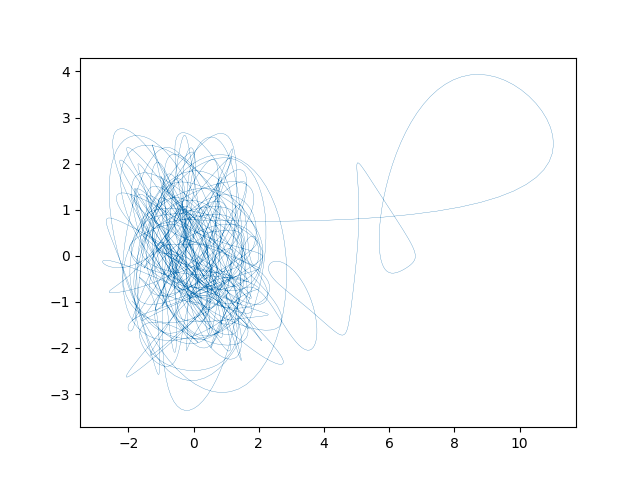

In [421]:
plt.figure()

clean_signal_A = bandpass(signal_A, [1, 30], 1e3)
clean_signal_B = bandpass(signal_B, [1, 30], 1e3)
L = 200
plt.plot(clean_signal_A[:-L], clean_signal_B[L:], alpha=1, lw=0.2)
plt.show()